In [12]:
import os
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
import numpy as np

In [ ]:
# # Define the folders containing training result CSVs
# folders = [
#     "no_dense_layer", "dense_32", "dense_64", "dense_64_32"
# ]
# folders = [
#     "64_128_64_LSTM", "128_64_LSTM"
# ]
# folders = [
#     "no_dense_layer", "dense_32", "dense_64", "dense_64_32", "64_128_64_LSTM", "128_64_LSTM"
# ]


# folders = [
#     "lstm_16_32_16_Adam", "lstm_32_16_Adam"
# ]
# folders = [
#     "lstm_16_32_16_Adam", "lstm_32_16_Adam", "lstm_16_32_16_SGD", "lstm_32_16_SGD"
# ]
# folders = [
#     "lstm_16_32_16_Adam", "lstm_16-32-16_Dense16", "lstm_16-32-16_Dense32", "lstm_16_32_16_dense32_16", "lstm_16_32_16_dense8", "lstm_16_32_16_dense16_8"
# ]
folders = [
    "lstm_4_8_4_Adam", "lstm_8_4_Adam", "lstm_16_8_Adam", "lstm_16_32_16_Adam", "lstm_32_16_Adam"
]



file_name = "training_results.csv"
base_output_folder = "/Users/pe3nu7/Downloads/PCA_generated_output"
base_statistic_output = "statistic_output"
statistic_file_base = "LSTM_Adam_SGD"


In [53]:
# Dictionary to store data for each model
model_data = {}

# Load data from each folder
for folder in folders:
    file_path = os.path.join(base_output_folder, folder, file_name)
    if os.path.exists(file_path):
        try:
            df = pd.read_csv(file_path, delimiter=",", header=0)  
            model_data[folder] = df
        except Exception as e:
            print(f"Error reading {file_path}: {e}")


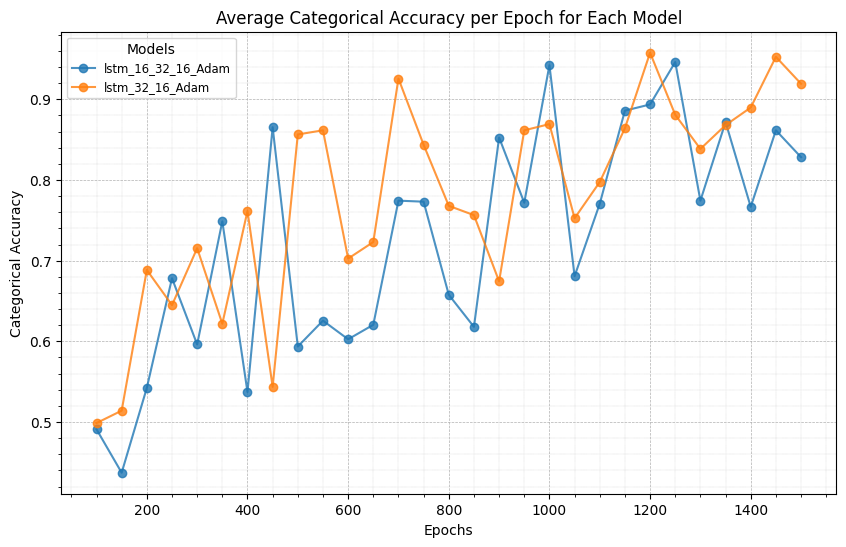

In [54]:
# Plot the average accuracy per epoch for each model without best-fit curves

plt.figure(figsize=(10, 6))

for folder, df in model_data.items():
    if "Epochs" in df.columns and "Categorical Accuracy" in df.columns:
        # Group by 'Epochs' to compute the average accuracy per epoch
        grouped = df.groupby("Epochs")["Categorical Accuracy"].mean().reset_index()
        epochs = grouped["Epochs"].values
        accuracies = grouped["Categorical Accuracy"].values
        
        # Plot the average accuracy as a line plot
        plt.plot(epochs, accuracies, label=f"{folder}", alpha=0.8, linestyle='-', marker='o')

plt.xlabel("Epochs")
plt.ylabel("Categorical Accuracy")
plt.title("Average Categorical Accuracy per Epoch for Each Model")
plt.legend(title="Models", fontsize='small', loc="best")
plt.grid(True)

# Enable minor ticks on both axes
plt.minorticks_on()
plt.grid(which="both", linestyle="--", linewidth=0.5)  # Show both major and minor grid lines
plt.grid(which="minor", linestyle=":", linewidth=0.3)  # Make minor grid lines more subtle

# Save plot path
statistic_file = "Accuracy_" + statistic_file_base
output_path = os.path.join(base_statistic_output, statistic_file + ".png")

# Save the figure
plt.savefig(output_path, dpi=300, bbox_inches="tight")

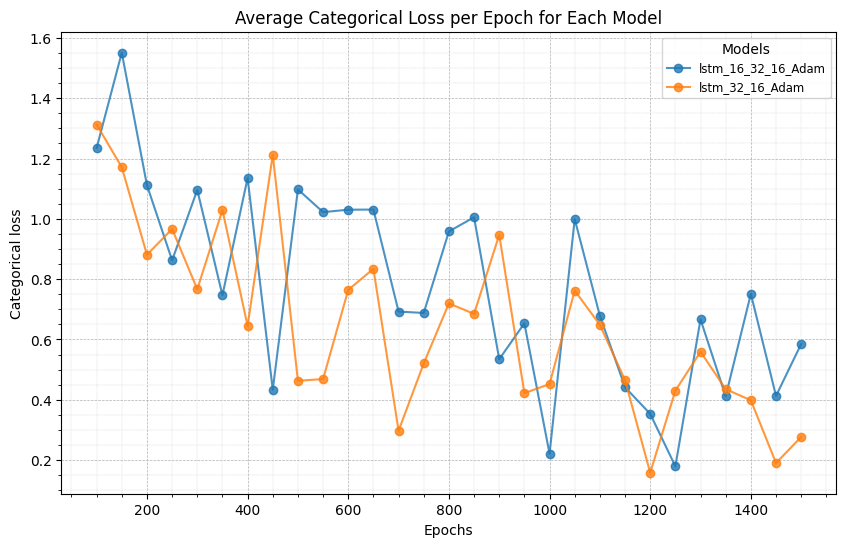

In [55]:
# Plot the average accuracy per epoch for each model without best-fit curves

plt.figure(figsize=(10, 6))

for folder, df in model_data.items():
    if "Epochs" in df.columns and "Loss" in df.columns:
        # Group by 'Epochs' to compute the average accuracy per epoch
        grouped = df.groupby("Epochs")["Loss"].mean().reset_index()
        epochs = grouped["Epochs"].values
        accuracies = grouped["Loss"].values
        
        # Plot the average accuracy as a line plot
        plt.plot(epochs, accuracies, label=f"{folder}", alpha=0.8, linestyle='-', marker='o')

plt.xlabel("Epochs")
plt.ylabel("Categorical loss")
plt.title("Average Categorical Loss per Epoch for Each Model")
plt.legend(title="Models", fontsize='small', loc="best")
plt.grid(True)

# Enable minor ticks on both axes
plt.minorticks_on()
plt.grid(which="both", linestyle="--", linewidth=0.5)  # Show both major and minor grid lines
plt.grid(which="minor", linestyle=":", linewidth=0.3)  # Make minor grid lines more subtle

# Save plot path
statistic_file = "loss_" + statistic_file_base
output_path = os.path.join(base_statistic_output, statistic_file + ".png")

# Save the figure
plt.savefig(output_path, dpi=300, bbox_inches="tight")

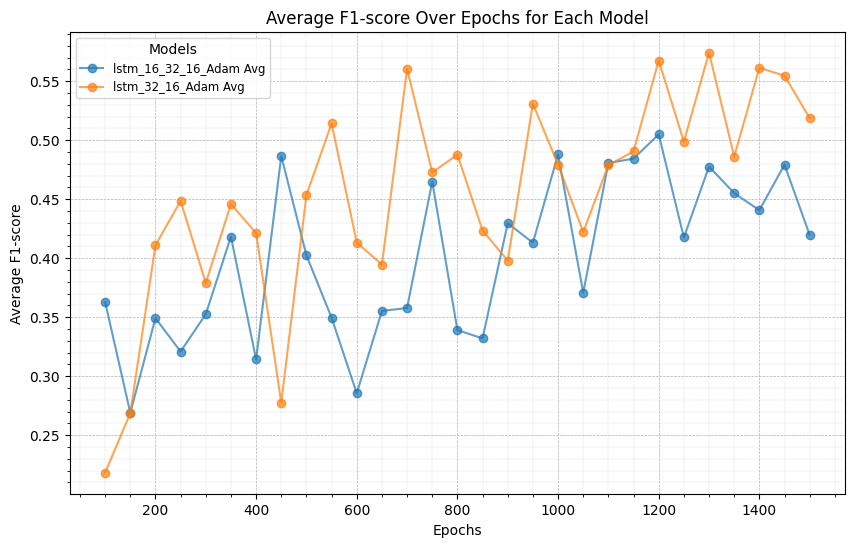

In [56]:
# Dictionary to store epoch-wise F1-score data for averaging per model
f1_scores_per_epoch_per_model = {}

# Process each model to compute average F1-score per epoch
for folder in folders:
    file_path = os.path.join(base_output_folder, folder, file_name)

    if os.path.exists(file_path):
        try:
            # Load CSV
            df_model = pd.read_csv(file_path, delimiter=",")

            # Ensure required columns exist
            if "Epochs" in df_model.columns and "Precision (OOD)" in df_model.columns and "Recall (OOD)" in df_model.columns:
                # Compute F1-score
                precision = df_model["Precision (OOD)"].fillna(0)
                recall = df_model["Recall (OOD)"].fillna(0)
                f1_scores = (2 * precision * recall) / (precision + recall)
                f1_scores = f1_scores.fillna(0)  # Handle divide-by-zero cases

                # Store F1-scores for averaging per epoch
                for epoch, f1 in zip(df_model["Epochs"], f1_scores):
                    if folder not in f1_scores_per_epoch_per_model:
                        f1_scores_per_epoch_per_model[folder] = {}
                    if epoch not in f1_scores_per_epoch_per_model[folder]:
                        f1_scores_per_epoch_per_model[folder][epoch] = []
                    f1_scores_per_epoch_per_model[folder][epoch].append(f1)

        except Exception as e:
            print(f"Error processing {folder} for averaged F1-score calculation: {e}")

# Compute average F1-score per epoch per model
average_f1_per_model = {}

for folder, epoch_data in f1_scores_per_epoch_per_model.items():
    avg_f1_per_epoch = {epoch: sum(f1_values) / len(f1_values) for epoch, f1_values in epoch_data.items()}
    average_f1_per_model[folder] = avg_f1_per_epoch

# Plot the F1-score per model with average trend per epoch
plt.figure(figsize=(10, 6))

for folder, avg_f1_data in average_f1_per_model.items():
    sorted_epochs = sorted(avg_f1_data.keys())
    sorted_avg_f1 = [avg_f1_data[epoch] for epoch in sorted_epochs]
    plt.plot(sorted_epochs, sorted_avg_f1, label=f"{folder} Avg", linestyle="-", marker="o", alpha=0.7)

# Configure plot
plt.xlabel("Epochs")
plt.ylabel("Average F1-score")
plt.title("Average F1-score Over Epochs for Each Model")
plt.legend(title="Models", fontsize="small", loc="best")
plt.grid(True)

# Enable minor ticks on both axes
plt.minorticks_on()
plt.grid(which="both", linestyle="--", linewidth=0.5)  # Show both major and minor grid lines
plt.grid(which="minor", linestyle=":", linewidth=0.3)  # Make minor grid lines more subtle


# Save plot path
statistic_file = "F1_" + statistic_file_base
output_path = os.path.join(base_statistic_output, statistic_file + ".png")

# Save the figure
plt.savefig(output_path, dpi=300, bbox_inches="tight")


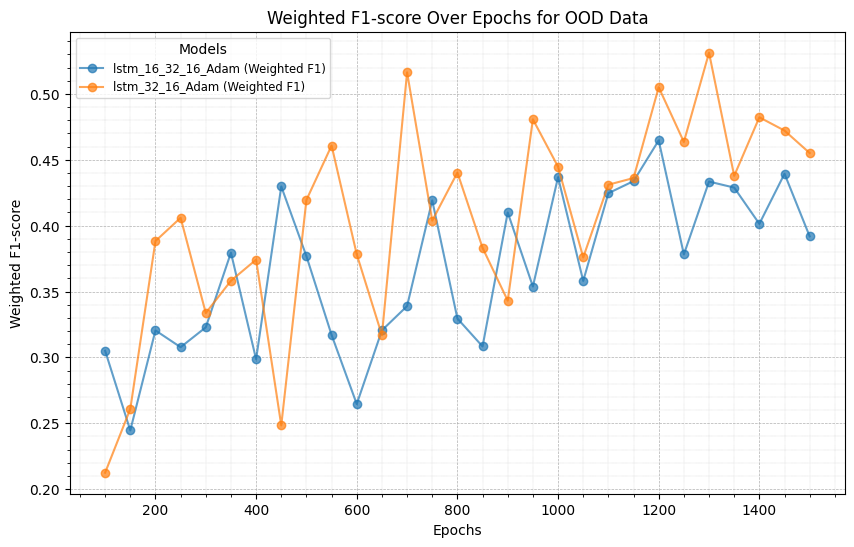

In [57]:
from collections import defaultdict
import numpy as np

# Dictionary to store weighted F1-score per epoch per model
weighted_f1_per_epoch_per_model = defaultdict(lambda: defaultdict(list))

# Process each model's CSV file
for folder in folders:
    file_path = os.path.join(base_output_folder, folder, file_name)
    if os.path.exists(file_path):
        try:
            df = pd.read_csv(file_path, delimiter=",")

            # Ensure required columns exist
            if "Epochs" in df.columns and "Classification Report (OOD)" in df.columns:
                # Extract weighted F1-score from classification report
                for epoch, report in zip(df["Epochs"], df["Classification Report (OOD)"]):
                    if isinstance(report, str):
                        try:
                            weighted_f1 = eval(report)["weighted avg"]["f1-score"]
                            weighted_f1_per_epoch_per_model[folder][epoch].append(weighted_f1)
                        except Exception as e:
                            print(f"Error processing epoch {epoch} in {folder}: {e}")

        except Exception as e:
            print(f"Error processing {folder} for weighted F1-score visualization: {e}")

# Compute the mean weighted F1-score for each epoch per model
average_f1_per_model = {}

for folder, epoch_data in weighted_f1_per_epoch_per_model.items():
    avg_f1_per_epoch = {epoch: np.mean(f1_values) for epoch, f1_values in epoch_data.items()}
    average_f1_per_model[folder] = avg_f1_per_epoch

# Plot the weighted F1-score over epochs
plt.figure(figsize=(10, 6))

for folder, avg_f1_data in average_f1_per_model.items():
    sorted_epochs = sorted(avg_f1_data.keys())
    sorted_f1_scores = [avg_f1_data[epoch] for epoch in sorted_epochs]
    plt.plot(sorted_epochs, sorted_f1_scores, label=f"{folder} (Weighted F1)", linestyle="-", marker="o", alpha=0.7)

# Configure plot
plt.xlabel("Epochs")
plt.ylabel("Weighted F1-score")
plt.title("Weighted F1-score Over Epochs for OOD Data")
plt.legend(title="Models", fontsize="small", loc="best")
plt.grid(True)

# Enable minor ticks
plt.minorticks_on()
plt.grid(which="both", linestyle="--", linewidth=0.5)
plt.grid(which="minor", linestyle=":", linewidth=0.3)

# Save the plot
statistic_file = "Weighted_F1_" + statistic_file_base
output_path = os.path.join(base_statistic_output, statistic_file + ".png")

# Save the figure
plt.savefig(output_path, dpi=300, bbox_inches="tight")


In [58]:
# Function to parse and clean confusion matrix strings
import re


def clean_conf_matrix(matrix_str):
    try:
        # Remove newlines and extra spaces
        matrix_str = matrix_str.replace("\n", " ").replace("[", "").replace("]", "")
        
        # Extract numbers using regex
        numbers = list(map(int, re.findall(r'\d+', matrix_str)))
        
        # Determine matrix size (assuming it's square)
        size = int(len(numbers) ** 0.5)
        
        # Reshape into a square matrix
        conf_matrix = np.array(numbers).reshape(size, size)
        
        return conf_matrix
    except Exception as e:
        print(f"Error parsing confusion matrix: {e}")
        return None

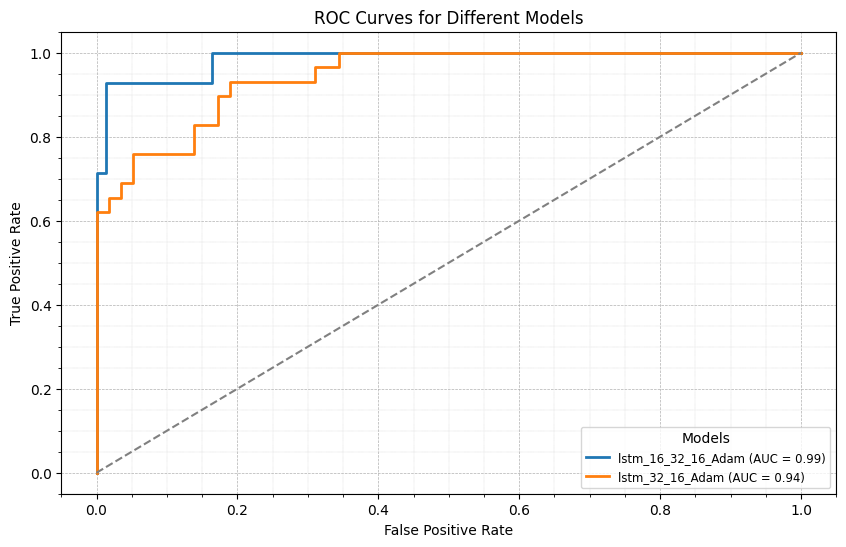

In [59]:
# Initialize figure for ROC curves
plt.figure(figsize=(10, 6))

# Dictionary to store AUC scores for each model
auc_scores = {}

# Process each model's CSV file
for folder in folders:
    file_path = os.path.join(base_output_folder, folder, file_name)
    
    if os.path.exists(file_path):
        try:
            # Load CSV
            df_model = pd.read_csv(file_path, delimiter=",")

            # Parse confusion matrices
            parsed_matrices = [clean_conf_matrix(cm) for cm in df_model["Conf Matrix (OOD)"]]

            # Extract y_true from parsed matrices
            y_true = []
            for conf_matrix in parsed_matrices:
                if conf_matrix is not None:
                    true_positive = np.trace(conf_matrix)  # Sum of diagonal elements
                    total_samples = np.sum(conf_matrix)  # Total instances in confusion matrix
                    y_true.append(1 if true_positive / total_samples > 0.5 else 0)
                else:
                    y_true.append(0)  # Default to 0 if parsing failed

            # Convert y_true to numpy array
            y_true = np.array(y_true)

            # Extract y_score from "Precision (OOD)" column
            y_score = df_model["Precision (OOD)"].to_numpy()

            # Compute ROC curve and AUC score
            fpr, tpr, _ = roc_curve(y_true, y_score)
            roc_auc = auc(fpr, tpr)

            # Store AUC score for reference
            auc_scores[folder] = roc_auc

            # Plot the ROC curve for this model
            plt.plot(fpr, tpr, lw=2, label=f"{folder} (AUC = {roc_auc:.2f})")

        except Exception as e:
            print(f"Error processing {folder}: {e}")

# Plot diagonal reference line
plt.plot([0, 1], [0, 1], color="gray", linestyle="--")

# Configure plot settings
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves for Different Models")
plt.legend(title="Models", fontsize="small", loc="best")
plt.grid(True)

# Enable minor ticks on both axes
plt.minorticks_on()
plt.grid(which="both", linestyle="--", linewidth=0.5)  # Show both major and minor grid lines
plt.grid(which="minor", linestyle=":", linewidth=0.3)  # Make minor grid lines more subtle

# Save plot path
statistic_file = "ROC_" + statistic_file_base
output_path = os.path.join(base_statistic_output, statistic_file + ".png")

# Save the figure
plt.savefig(output_path, dpi=300, bbox_inches="tight")


## Plot AUC

In [60]:
import tensorflow as tf
from tensorflow.keras.layers import LSTM

# Custom function to override LSTM layer and remove 'time_major'
def custom_lstm(*args, **kwargs):
    kwargs.pop("time_major", None)  # Remove unsupported argument
    return LSTM(*args, **kwargs)

# Load the model with custom LSTM override
model = tf.keras.models.load_model(
    "/Users/pe3nu7/Downloads/PCA_Raw_output/lstm_16_32_16_SGD/_SGD_epochs1500_run3/model.h5",
    custom_objects={"LSTM": custom_lstm}
)

print("Model loaded successfully!")


/opt/homebrew/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model loaded successfully!


Error loading model: Unrecognized keyword arguments passed to LSTM: {'time_major': False}
Unique values in Y_test: [0 1]
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 108ms/step


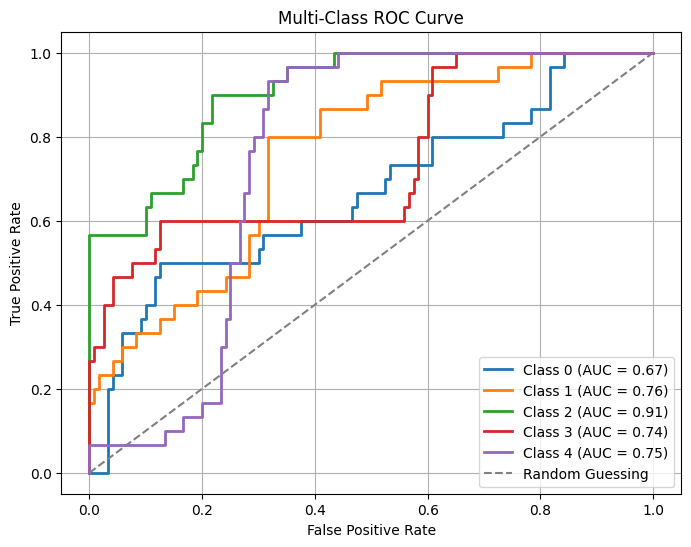

In [61]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

# Define the model path (Ensure this is correct!)
model_path = "/Users/pe3nu7/Downloads/PCA_Raw_output/lstm_16_32_16_SGD/_SGD_epochs1500_run3/model.h5"

try:
    # Load the trained model
    model = tf.keras.models.load_model(model_path)
    print("Model loaded successfully!")
except Exception as e:
    print(f"Error loading model: {e}")

# Load the test dataset
X_test = np.load("/Users/pe3nu7/Documents/SUTD/Y3S2/Computation Data Science/project/Data_Science_Project/action_detection/mp_data_outofdomain_pca_processed/skip_1_testsize_100_1/X_test.npy")
Y_test = np.load("/Users/pe3nu7/Documents/SUTD/Y3S2/Computation Data Science/project/Data_Science_Project/action_detection/mp_data_outofdomain_pca_processed/skip_1_testsize_100_1/Y_test.npy")

# Debugging: Check unique values in Y_test
print("Unique values in Y_test:", np.unique(Y_test))

# Define the correct class range explicitly
expected_classes = [0, 1, 2, 3, 4]  # Adjust if needed

# Convert Y_test to one-hot encoding using the expected class range
Y_test_one_hot = label_binarize(Y_test, classes=expected_classes)

# Get model predictions (Softmax outputs with shape (samples, num_classes))
Y_scores = model.predict(X_test)

# Ensure Y_scores shape is correct
if Y_scores.shape[1] != len(expected_classes):
    raise ValueError(f"Y_scores has shape {Y_scores.shape}, but expected {len(expected_classes)} classes.")

# Compute ROC curve for each class
plt.figure(figsize=(8, 6))
for i in range(len(expected_classes)):
    fpr, tpr, _ = roc_curve(Y_test_one_hot[:, i], Y_scores[:, i])
    roc_auc = auc(fpr, tpr)

    plt.plot(fpr, tpr, lw=2, label=f"Class {expected_classes[i]} (AUC = {roc_auc:.2f})")

# Plot diagonal reference line
plt.plot([0, 1], [0, 1], linestyle="--", color="gray", label="Random Guessing")

# Configure plot
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Multi-Class ROC Curve")
plt.legend(loc="best")
plt.grid()

# Show the plot
plt.show()



In [62]:
import numpy as np
from sklearn.metrics import roc_auc_score, roc_curve

# Compute AUC scores for each class
auc_per_class = []
valid_classes = []

for i in range(len(expected_classes)):
    y_true = Y_test_one_hot[:, i]
    y_score = Y_scores[:, i]

    # Ensure the class has both 0s and 1s in true labels
    if np.unique(y_true).size > 1:
        
        # Ensure the scores are not constant
        if np.unique(y_score).size > 1:
            
            # Compute AUC using roc_auc_score() instead of manually computing auc()
            valid_classes.append(i)
            auc_value = roc_auc_score(y_true, y_score)
            auc_per_class.append(auc_value)
        
        else:
            print(f"Skipping Class {i} (Constant prediction scores)")
    else:
        print(f"Skipping Class {i} (Only one label present)")

# Compute Macro-Averaged AUC (Equal Weighting)
macro_auc = np.mean(auc_per_class) if auc_per_class else None

# Compute Weighted AUC (Weighted by Class Distribution)
class_counts = np.sum(Y_test_one_hot, axis=0)  # Number of samples per class
class_weights = class_counts / np.sum(class_counts)  # Normalize to get weights
weighted_auc = np.sum(np.array(auc_per_class) * class_weights[valid_classes]) if auc_per_class else None

# Compute Micro-Averaged AUC
micro_auc = roc_auc_score(Y_test_one_hot, Y_scores, average="micro") if auc_per_class else None

# Print Results
print(f"Macro-Averaged AUC  : {macro_auc:.4f}" if macro_auc else "Macro AUC could not be computed")
print(f"Weighted AUC         : {weighted_auc:.4f}" if weighted_auc else "Weighted AUC could not be computed")
print(f"Micro-Averaged AUC   : {micro_auc:.4f}" if micro_auc else "Micro AUC could not be computed")

# Print valid class AUCs
if auc_per_class:
    print("AUC per valid class:", {f"Class {valid_classes[i]}": auc_per_class[i] for i in range(len(auc_per_class))})


Macro-Averaged AUC  : 0.7651
Weighted AUC         : 0.7651
Micro-Averaged AUC   : 0.7678
AUC per valid class: {'Class 0': 0.6675, 'Class 1': 0.7566666666666667, 'Class 2': 0.9069444444444444, 'Class 3': 0.7424999999999999, 'Class 4': 0.7516666666666667}


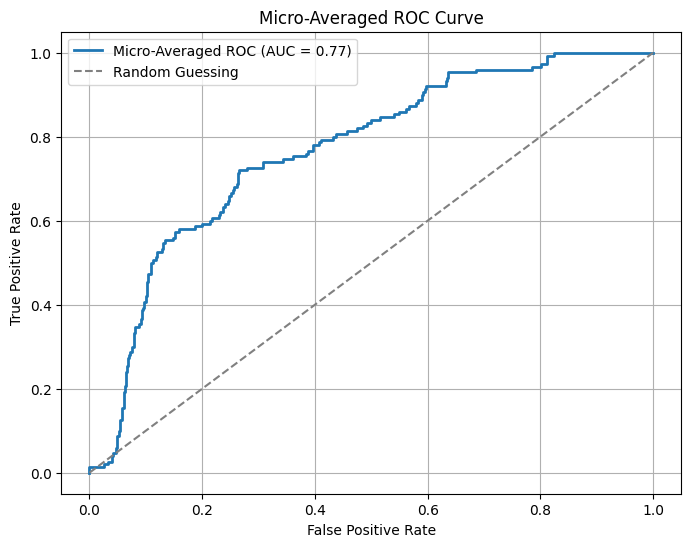

In [63]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve

# Compute micro-averaged ROC curve
fpr_micro, tpr_micro, _ = roc_curve(Y_test_one_hot.ravel(), Y_scores.ravel())

# Plot ROC Curve
plt.figure(figsize=(8, 6))
plt.plot(fpr_micro, tpr_micro, lw=2, label=f"Micro-Averaged ROC (AUC = {micro_auc:.2f})")
plt.plot([0, 1], [0, 1], linestyle="--", color="gray", label="Random Guessing")

# Configure plot
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Micro-Averaged ROC Curve")
plt.legend(loc="best")
plt.grid()

# Show the plot
plt.show()


# Plot Micro-averaged ROC curve of each model configuration
Reads through all the trained model configuration and get the highest micro-averaged AUC of each. Then plots that curve.

In [64]:
import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score, roc_curve
from tensorflow.keras.layers import LSTM

# Convert Y_test to one-hot encoding if necessary
num_classes = len(np.unique(Y_test))
Y_test_one_hot = np.eye(num_classes)[Y_test] if len(Y_test.shape) == 1 else Y_test

# Custom LSTM override function to remove `time_major`
def custom_lstm(*args, **kwargs):
    kwargs.pop("time_major", None)  # Remove unsupported argument
    return LSTM(*args, **kwargs)

# Store the best model per configuration with epoch details
best_models = {}
best_auc_scores = {}
best_epochs = {}

# Process each model folder
for folder in folders:
    model_folder_path = os.path.join(base_output_folder, folder)
    
    if not os.path.exists(model_folder_path):
        print(f"Skipping {folder} (Path does not exist)")
        continue

    best_auc = 0
    best_model_path = None
    best_epoch = None

    # Iterate through subfolders to find models
    for subfolder in os.listdir(model_folder_path):
        model_path = os.path.join(model_folder_path, subfolder, "model.h5")

        if not os.path.exists(model_path):
            continue

        try:
            # Extract epoch number from folder name (Assuming `_epochsX_` format)
            epoch_info = [int(s.split("epochs")[-1].split("_")[0]) for s in subfolder.split("_") if "epochs" in s]
            epoch_number = epoch_info[0] if epoch_info else None

            # Load model with custom LSTM override
            model = tf.keras.models.load_model(model_path, custom_objects={"LSTM": custom_lstm})
            
            # Get predictions silently
            Y_scores = model.predict(X_test, verbose=0)

            # Compute micro-AUC
            micro_auc = roc_auc_score(Y_test_one_hot, Y_scores, average="micro")

            # Track the best model
            if micro_auc > best_auc:
                best_auc = micro_auc
                best_model_path = model_path
                best_epoch = epoch_number

        except Exception as e:
            print(f"Error processing {model_path}: {e}")

    if best_model_path:
        best_models[folder] = best_model_path
        best_auc_scores[folder] = best_auc
        best_epochs[folder] = best_epoch

# Display best AUC scores and epoch numbers per model configuration
best_epochs, best_auc_scores


/opt/homebrew/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/opt/homebrew/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/opt/homebrew/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/opt/homebrew/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` arg

({'lstm_16_32_16_Adam': 750, 'lstm_32_16_Adam': 300},
 {'lstm_16_32_16_Adam': 0.8085111111111111,
  'lstm_32_16_Adam': 0.8063666666666667})

/opt/homebrew/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/opt/homebrew/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


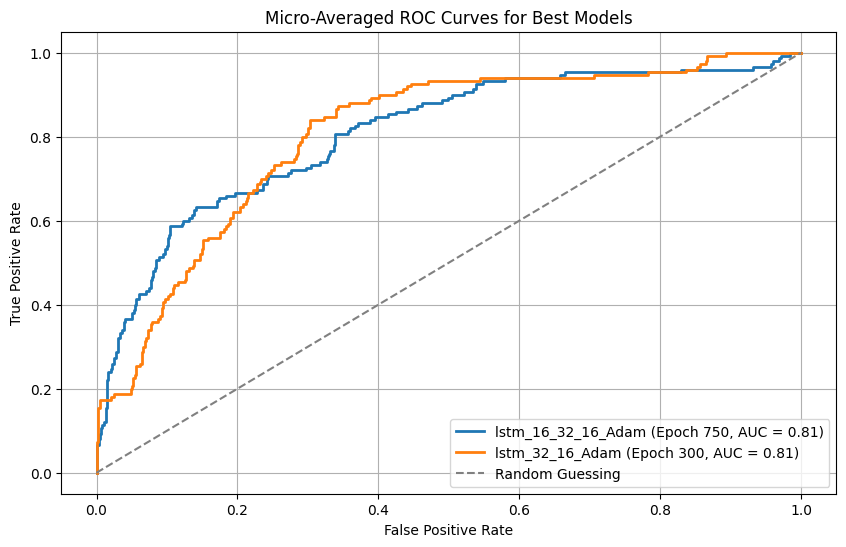

In [66]:
# Plot ROC Curves for Best Models
plt.figure(figsize=(10, 6))

for folder, best_model_path in best_models.items():
    try:
        # Load best model
        best_model = tf.keras.models.load_model(best_model_path, custom_objects={"LSTM": custom_lstm})
        Y_scores = best_model.predict(X_test, verbose=0)

        # Compute micro-averaged ROC curve
        fpr_micro, tpr_micro, _ = roc_curve(Y_test_one_hot.ravel(), Y_scores.ravel())

        # Plot the ROC curve
        plt.plot(fpr_micro, tpr_micro, lw=2, label=f"{folder} (Epoch {best_epochs[folder]}, AUC = {best_auc_scores[folder]:.2f})")

    except Exception as e:
        print(f"Error loading best model {best_model_path}: {e}")

# Plot diagonal reference line
plt.plot([0, 1], [0, 1], linestyle="--", color="gray", label="Random Guessing")

# Configure plot settings
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Micro-Averaged ROC Curves for Best Models")
plt.legend(loc="best")
plt.grid()

# Show the plot
plt.show()